# CAPSTONE
Kehinde Ajayi

In [1]:
# import sys

# # If you are running this notebook in Colaboratory, run this cell and follow the
# # instructions to authenticate your GCP account. This provides access to your
# # Google Cloud Storage bucket and lets us submit training jobs and prediction
# # requests.

# if 'google.colab' in sys.modules:
#   from google.colab import auth as google_auth
#   google_auth.authenticate_user()

# # If you are running this notebook locally, replace the string below with the
# # path to your service account key and run this cell to authenticate your GCP
# # account.
# else:
#   % env GOOGLE_APPLICATION_CREDENTIALS '/path/to/your/service-account-key.json'

In [2]:
## check if notebook is running on Colab--if so, run appropriate installs and mount Google Drive
# https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab

if 'google.colab' in str(get_ipython()):
  # install RDKit and DeepChem
  !pip install rdkit-pypi chembl_webresource_client --pre deepchem 
  # mount Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import time
import os.path

from tqdm.auto import tqdm

from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, PandasTools, Descriptors, Draw, rdmolops, rdMolDescriptors, Lipinski, rdmolfiles, rdFMCS

from IPython.core.display import HTML

import deepchem as dc

from chembl_webresource_client.new_client import new_client

from sklearn.decomposition import PCA

import mols2grid
from clusterama import ButinaCluster, display_cluster_members

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## Functions

In [4]:
# function for calculating number of 'Rule of 5' violations
def ro5_violations(df_row):
    
    violations = 0
    if df_row.H_bond_donors > 5:
        violations += 1
    if df_row.H_bond_acceptors > 10:
        violations += 1
    if df_row.mw > 500:
        violations += 1
    if df_row.logP > 5:
        violations += 1
        
    return violations

In [5]:
# function for calculating various molecular features and adding to dataframe
def calculate_properties(df):
    
    # # add image of molecule to dataframe
    # PandasTools.AddMoleculeColumnToFrame(herg_df, 'SMILES', 'Mol')


    df['mw'] = [Descriptors.MolWt(x) for x in tqdm(df.Mol, desc="Molecular Weight")]
    df['logP'] = [Descriptors.MolLogP(x) for x in tqdm(df.Mol, desc="LogP")] # Wildman and Crippen JCICS 39:868-73 (1999)
    df['PSA'] = [Descriptors.TPSA(x) for x in tqdm(df.Mol, desc="Polar Surface Area")] # J. Med. Chem. 43:3714-7, (2000) See the section in the RDKit book describing differences to the original publication.
    df['H_bond_donors'] = [Lipinski.NumHDonors(x) for x in tqdm(df.Mol, desc="Number of H-bond donors")]
    df['H_bond_acceptors'] = [Lipinski.NumHAcceptors(x) for x in tqdm(df.Mol, desc="Number of H-bond acceptors")]
    df['num_heteroatoms'] = [Lipinski.NumHeteroatoms(x) for x in tqdm(df.Mol, desc="Number of heteroatoms")]
    df['total_num_rings'] = [Lipinski.RingCount(x) for x in tqdm(df.Mol, desc="Total number of rings")]
    df['aromatic_rings'] = [Lipinski.NumAromaticRings(x) for x in tqdm(df.Mol, desc="Number of aromatic rings")]
    df['num_rotatable_bonds'] = [Lipinski.NumRotatableBonds(x) for x in tqdm(df.Mol, desc="Number of rotatable bonds")]
    df['num_stereocenters'] = [rdMolDescriptors.CalcNumAtomStereoCenters(x) for x in tqdm(df.Mol, desc="Number of stereocenters")]
    df['formal_charge'] = [rdmolops.GetFormalCharge(x) for x in tqdm(df.Mol, desc="Formal Charge")]
    df['SMILES_length'] = [len(x) for x in herg_df['SMILES']]
    df['ro5_violations'] = df.apply(ro5_violations, axis=1)
    df['adjacency_matrix'] = [rdmolops.GetAdjacencyMatrix(x) for x in tqdm(df.Mol, desc="Adjacency Matrix")]
    # df['distance_matrix'] = [rdmolops.GetDistanceMatrix(x) for x in df.Mol]

    
    # return df
    

In [6]:
# workaround for bug where molecular structure does not print with dataframe
# https://github.com/rdkit/rdkit/issues/2673
def show(df):
    return HTML(df.to_html(notebook=True))


In [7]:
# check if notebook is running on Colab and set path for data file 

def get_home_path():
  if 'google.colab' in str(get_ipython()):
    file_path = '/content/drive/MyDrive/GA/Capstone/ka_capstone'
  else:
    file_path = '..'
  
  return file_path


In [8]:
# view all columns in dataframe
pd.set_option('display.max.columns', None)

## Download and read data

### training and validation data

In [9]:
# Get hERG data from URL
url = 'https://dataverse.harvard.edu/api/access/datafile/'

In [10]:
# Download hERG data to file if it doesn't exist
if not os.path.exists(f'{get_home_path()}/data/raw/hERG_Central.tsv'):
    res = requests.get(url+'5724875')
    with open(f'{get_home_path()}/data/raw/hERG_Central.tsv','wb') as tsv:
        tsv.write(res.content)


In [11]:
# read hERG data into dataframe 
herg_df = pd.read_csv(f'{get_home_path()}/data/raw/hERG_Central.tsv', delimiter='\t')


In [32]:

herg_df.sample(5)

,ID,X,hERG_at_1uM,hERG_at_10uM,hERG_inhib
99077,17509692,Cc1cccc(-n2cnc3cc(C(=O)N4CCc5ccccc54)ccc32)c1,-6.5409,-61.48452,1
267520,24824655,Cc1cc(C)n(C(=O)/C(C#N)=N/Nc2cc(Cl)cc(Cl)c2)n1,9.8880,11.25168,0
13490,846946,Cc1ccc(N2CC(C(=O)OCC(=O)C(C)(C)C)CC2=O)cc1C,2.5929,-1.56722,0
13291,49722309,CC1(C)Cc2c(cnn2-c2ccccc2)C(NC(=O)CCN2CCCC2=O)C1,14.1506,6.21238,0
222163,845035,O=C(CSc1nnc(-c2cccnc2)n1C1CCCCC1)NC1CCCCC1,-6.6648,-17.36342,0


### Testing data

In [ ]:

target = new_client.target
activity = new_client.activity
herg = target.filter(pref_name__iexact='hERG').only('target_chembl_id')[0]
herg_activities = activity.filter(target_chembl_id=herg['target_chembl_id']) # .filter(standard_type="IC50")

len(herg_activities)

25303

In [ ]:
herg_activities

[{'activity_comment': None, 'activity_id': 111169, 'activity_properties': [], 'assay_chembl_id': 'CHEMBL820995', 'assay_description': 'Affinity for HERG voltage-gated potassium channel subunit Kv11.1', 'assay_type': 'B', 'assay_variant_accession': None, 'assay_variant_mutation': None, 'bao_endpoint': 'BAO_0000179', 'bao_format': 'BAO_0000357', 'bao_label': 'single protein format', 'canonical_smiles': 'CN1CCN(C(=O)c2ccc3[nH]c(-c4cc5ccccc5nc4O)cc3c2)CC1', 'data_validity_comment': 'Non standard unit for type', 'data_validity_description': 'Units for this activity type are unusual and may be incorrect (or the standard_type may be incorrect)', 'document_chembl_id': 'CHEMBL1137936', 'document_journal': 'Bioorg. Med. Chem. Lett.', 'document_year': 2004, 'ligand_efficiency': None, 'molecule_chembl_id': 'CHEMBL324489', 'molecule_pref_name': None, 'parent_molecule_chembl_id': 'CHEMBL324489', 'pchembl_value': None, 'potential_duplicate': False, 'qudt_units': 'http://www.openphacts.org/units/Nanom

## FEATURE GENERATION


In [ ]:
# rename ID and X columns
herg_df = herg_df.rename(columns={'ID':'Pubchem_SID', 'X':'SMILES', 'hERG_inhib': 'herg_inhibitor'}, errors='ignore')

In [ ]:
# list rows with duplicated SMILES
dup_smiles = herg_df.loc[herg_df.SMILES.duplicated(keep=False),:].sort_values(by='SMILES')
print(dup_smiles.shape)
show(dup_smiles)

(28, 5)


,Pubchem_SID,SMILES,hERG_at_1uM,hERG_at_10uM,herg_inhibitor
176139,3713680,CC(=O)/C=C(/C)NC(Cc1c[nH]c2ccccc12)C(=O)O,10.1423,-2.94762,0
23180,14727836,CC(=O)/C=C(/C)NC(Cc1c[nH]c2ccccc12)C(=O)O,0.1880,0.62798,0
39912,26665338,CCN(CC)CCN=Cc1c(O)n(Cc2ccccc2)c(=O)[nH]c1=O,-11.7853,-31.50462,0
132345,14739636,CCN(CC)CCN=Cc1c(O)n(Cc2ccccc2)c(=O)[nH]c1=O,-3.0354,-31.31392,0
291026,14738079,CCN(CC)c1ccc(N=Cc2c(O)n(Cc3ccccc3)c(=O)[nH]c2=...,14.2244,18.51488,0
21017,14729657,CCN(CC)c1ccc(N=Cc2c(O)n(Cc3ccccc3)c(=O)[nH]c2=...,5.1098,-0.76762,0
187163,49665950,COc1ccc2[n-]c(S(=O)Cc3ncc(C)c(OC)c3C)nc2c1.COc...,16.2572,16.29698,0
56844,49681830,COc1ccc2[n-]c(S(=O)Cc3ncc(C)c(OC)c3C)nc2c1.COc...,9.3664,-0.36122,0
166161,56422115,C[C@H]1CCC/C=C/[C@@H]2C[C@H](O)C[C@H]2[C@H](O)...,14.3799,13.97648,0
214665,56463468,C[C@H]1CCC/C=C/[C@@H]2C[C@H](O)C[C@H]2[C@H](O)...,15.9088,7.27398,0


The dataset contains 14 pairs of duplicate compounds, but each duplicate has different inhibition values at 1uM and 10uM! These will be dropped.

In [ ]:
# drop all copies of duplicated compounds
herg_df = herg_df.drop(index=dup_smiles.index, errors='ignore')

In [ ]:
# add image of molecule to dataframe
PandasTools.AddMoleculeColumnToFrame(herg_df, 'SMILES', 'Mol')

In [ ]:
# add calculated features to dataframe
calculate_properties(herg_df)

  0%|          | 0/306865 [00:00<?, ?it/s]

  0%|          | 0/306865 [00:00<?, ?it/s]

  0%|          | 0/306865 [00:00<?, ?it/s]

,Pubchem_SID,SMILES,hERG_at_1uM,hERG_at_10uM,herg_inhibitor,Mol,mw,logP,PSA,H_bond_donors,H_bond_acceptors,num_heteroatoms,total_num_rings,aromatic_rings,num_rotatable_bonds,num_stereocenters,formal_charge,SMILES_length,ro5_violations,adjacency_matrix
117895,14733986,CCOC(=O)C1=C(C)OC(N)=C(C#N)C1c1ccc(O)c(OC)c1,3.4151,2.39368,0,,330.340,2.04558,114.80,2,7,7,2,1,4,1,0,44,0,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
135189,862412,CCCCn1c2nc3ccccc3nc2c2c(=O)n(C(C)CC)cnc21,-3.7568,-18.21302,0,,349.438,4.06550,65.60,0,6,6,4,4,5,1,0,41,0,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
197832,17409380,COc1ccc(Oc2nc3ccccc3n(C)c2=O)cc1,-7.9547,-16.75282,0,,282.299,2.73440,53.35,0,5,5,3,3,3,0,0,32,0,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
232633,17433092,CSc1ncc(Cl)c(C(=O)Nc2cccc(C)c2)n1,9.5843,-4.23932,0,,293.779,3.41262,54.88,1,4,6,2,2,3,0,0,33,0,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
149000,49723520,O=C(NC1CCCN(c2ccc(C(F)(F)F)cn2)C1)c1cc(Cl)ccc1F,12.4237,5.33698,0,,401.791,4.29170,45.23,1,3,9,3,2,3,1,0,47,0,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."

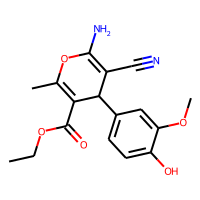
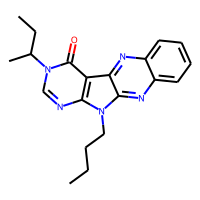
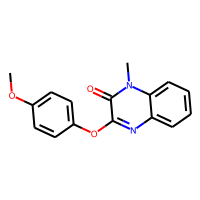
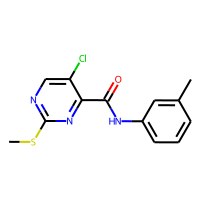
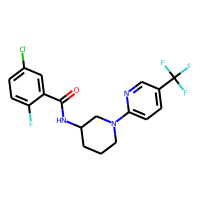

In [ ]:
show(herg_df.sample(5))

In [ ]:
## from RdKit cookbook (https://www.rdkit.org/docs/Cookbook.html)
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    Chem.Draw(mol)
    # atom.SetAtomMapNum(0)


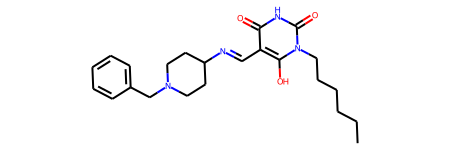

In [ ]:
herg_df.Mol[6]

In [ ]:

# mol_with_atom_index(herg_df.Mol[6])


In [ ]:
Chem.MolToSmiles(herg_df.Mol[5])


'Fc1ccc(Oc2ncccn2)c(F)c1'

In [ ]:
A = rdmolops.GetAdjacencyMatrix(herg_df.Mol[5])
A = np.asmatrix(A)
A

matrix([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=int32)

In [ ]:
C = [1, 0, 0, 0]
N = [0, 1, 0, 0]
O = []

In [ ]:
(rdmolops.GetDistanceMatrix(herg_df.Mol[5]))

array([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 8., 7., 3., 4., 2.],
       [1., 0., 1., 2., 3., 4., 5., 6., 7., 8., 7., 6., 2., 3., 1.],
       [2., 1., 0., 1., 2., 3., 4., 5., 6., 7., 6., 5., 3., 4., 2.],
       [3., 2., 1., 0., 1., 2., 3., 4., 5., 6., 5., 4., 2., 3., 3.],
       [4., 3., 2., 1., 0., 1., 2., 3., 4., 5., 4., 3., 1., 2., 2.],
       [5., 4., 3., 2., 1., 0., 1., 2., 3., 4., 3., 2., 2., 3., 3.],
       [6., 5., 4., 3., 2., 1., 0., 1., 2., 3., 2., 1., 3., 4., 4.],
       [7., 6., 5., 4., 3., 2., 1., 0., 1., 2., 3., 2., 4., 5., 5.],
       [8., 7., 6., 5., 4., 3., 2., 1., 0., 1., 2., 3., 5., 6., 6.],
       [9., 8., 7., 6., 5., 4., 3., 2., 1., 0., 1., 2., 6., 7., 7.],
       [8., 7., 6., 5., 4., 3., 2., 3., 2., 1., 0., 1., 5., 6., 6.],
       [7., 6., 5., 4., 3., 2., 1., 2., 3., 2., 1., 0., 4., 5., 5.],
       [3., 2., 3., 2., 1., 2., 3., 4., 5., 6., 5., 4., 0., 1., 1.],
       [4., 3., 4., 3., 2., 3., 4., 5., 6., 7., 6., 5., 1., 0., 2.],
       [2., 1., 2., 3., 2., 3., 4.

In [ ]:
D = np.array(np.sum(A, axis=0))[0]
D = np.matrix(np.diag(D))
D

matrix([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]])

In [ ]:
herg_df['label'] = ["active" if i == 1 else "inactive" for i in herg_df.herg_inhibitor]

In [ ]:
%%time 
# # herg_df['Mol'].map(lambda x: Descriptors.MolWt(x))
# # [Descriptors.MolWt(x) for x in herg_df.Mol]
# feat = dc.feat.RDKitDescriptors()
# arr = feat.featurize(herg_df.Mol)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


### Save processed data 

In [ ]:
# save processed dataframe to csv 
herg_df.drop(columns=['Mol']).to_csv(f'{get_home_path()}/data/interim/herg_data.csv', index=False)

In [ ]:
# save processed dataframe with structures to sd file
PandasTools.WriteSDF(herg_df, out=f'{get_home_path()}/data/interim/herg-data-with-structures.sdf', molColName='Mol', idName='Pubchem_SID', properties=list(herg_df.columns))